In [78]:
import os
import csv
import shutil
import datetime
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import mediapipe as mp
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

In [3]:
def angle_calculator(a, b, c):
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

In [4]:
# Guidline and coordinations

corner_upper_left_nose = 49
corner_upper_right_nose = 279
corner_lower_left_nose = 48
corner_lower_right_nose = 278
center_upper_nose = 6
center_lower_nose = 1
middle_center_nose = 5
lower_center_left_nose = 44
lower_center_right_nose = 274

nose_coordinates = [49, 279, 48, 278, 6, 1, 5, 44, 274]

In [5]:
test_image = cv.imread("Test Image.jpg")
test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    result = holistic.process(test_image)

In [6]:
def nose_landmarker(rgb_image, num_landmark, output=1):
    if type(num_landmark) == int:
        x = int((result.face_landmarks.landmark[num_landmark].x)*rgb_image.shape[1])
        y = int((result.face_landmarks.landmark[num_landmark].y)*rgb_image.shape[0])
        cv.circle(rgb_image, (x, y), radius=5, color=(50, 100, 255), thickness=10)
    elif type(num_landmark) == list:
        x = []
        y = []
        for val in num_landmark:
            x.append(int((result.face_landmarks.landmark[val].x)*rgb_image.shape[1]))
            y.append(int((result.face_landmarks.landmark[val].y)*rgb_image.shape[0]))
        for i in range(len(x)):
            cv.circle(rgb_image, (x[i], y[i]), radius=5, color=(255, 10, 20), thickness=10)
    
    # Optional
    if output==1:
        # Returns the image with a circle pointed on the specific area
        return rgb_image
    elif output==2:
        # Returns only the the coordinates of the image
        return x, y

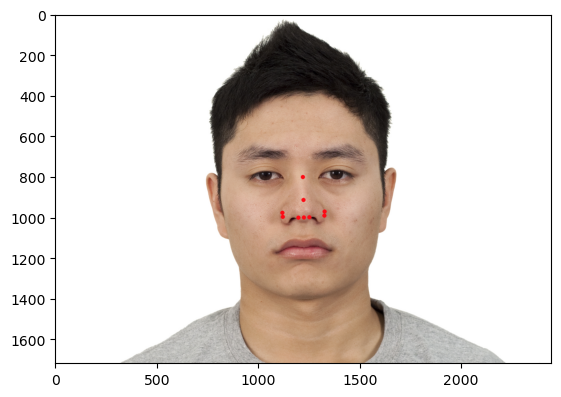

In [7]:
new_image = nose_landmarker(test_image, nose_coordinates, 1)
plt.imshow(new_image)
plt.show()

In [8]:
csv_rows = ['image_name', 'corner_upper_left_nose_x', 'corner_upper_right_nose_x', 'corner_lower_left_nose_x',
            'corner_lower_right_nose_x', 'center_upper_nose_x', 'center_lower_nose_x', 'middle_center_nose_x',
            'lower_center_left_nose_x', 'lower_center_right_nose_x',
            'corner_upper_left_nose_y', 'corner_upper_right_nose_y', 'corner_lower_left_nose_y',
            'corner_lower_right_nose_y', 'center_upper_nose_y', 'center_lower_nose_y', 'middle_center_nose_y',
            'lower_center_left_nose_y', 'lower_center_right_nose_y']

with open("Nose Landmarks.csv", 'w') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(csv_rows)

In [8]:
dataset_path = "C:/Users/Sina/Desktop/temp/Arbirtary Project/Dataset"
images_names = os.listdir(f"{dataset_path}/")
nose_images = []

for f in images_names:
    nose_images.append(f"{dataset_path}/{f}")

In [10]:
# nose_coordinates = [49, 279, 48, 278, 6, 1, 5, 44, 274]
start = datetime.datetime.now()

temp = 0
for image in nose_images:
    img = cv.imread(image)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        result = holistic.process(img)
        
    x, y = nose_landmarker(img, nose_coordinates, 2)
    coords = x+y
    
    combined_list = [images_names[temp]]
    for i in range(len(coords)):
        combined_list.append(coords[i])
    with open("Nose Landmarks.csv", 'a', newline='') as csvfile:
        csv_writer = csv.writer(csvfile, lineterminator='\n')
        csv_writer.writerow(combined_list)
        
    temp+=1

end = datetime.datetime.now()

print("Time it takes:", end-start)

Time it takes: 0:05:46.945402


In [9]:
df = pd.read_csv("Nose Landmarks.csv")
df.head(5)

,image_name,corner_upper_left_nose_x,corner_upper_right_nose_x,corner_lower_left_nose_x,corner_lower_right_nose_x,center_upper_nose_x,center_lower_nose_x,middle_center_nose_x,lower_center_left_nose_x,lower_center_right_nose_x,corner_upper_left_nose_y,corner_upper_right_nose_y,corner_lower_left_nose_y,corner_lower_right_nose_y,center_upper_nose_y,center_lower_nose_y,middle_center_nose_y,lower_center_left_nose_y,lower_center_right_nose_y


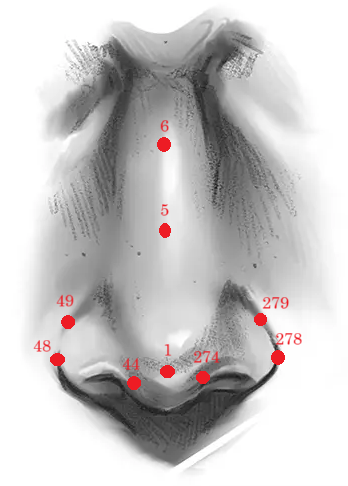

* Guidline and coordinations

    * corner_upper_left_nose = 49
    * corner_upper_right_nose = 279
    * corner_lower_left_nose = 48
    * corner_lower_right_nose = 278
    * center_upper_nose = 6
    * center_lower_nose = 1
    * middle_center_nose = 5
    * lower_center_left_nose = 44
    * lower_center_right_nose = 274

In [138]:
csv_features = ["image_name", "upper_corner", "lower_corner", "all_center", "upper_angle", "middle_angle",
                "lower_angle", "lower_distance"]

with open("Nose Features.csv", 'w') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(csv_features)

In [10]:
df.head()

,image_name,corner_upper_left_nose_x,corner_upper_right_nose_x,corner_lower_left_nose_x,corner_lower_right_nose_x,center_upper_nose_x,center_lower_nose_x,middle_center_nose_x,lower_center_left_nose_x,lower_center_right_nose_x,corner_upper_left_nose_y,corner_upper_right_nose_y,corner_lower_left_nose_y,corner_lower_right_nose_y,center_upper_nose_y,center_lower_nose_y,middle_center_nose_y,lower_center_left_nose_y,lower_center_right_nose_y


In [11]:
def nose_feature_extractor(image_name):
    image_data = df.loc[(df['image_name'] == image_name)]
    
    # landmark  number: 49
    x_upper_corners_left = image_data["corner_upper_left_nose_x"].values[0]
    y_upper_corners_left = image_data["corner_upper_left_nose_y"].values[0]
    upper_corners_left = np.array([x_upper_corners_left, y_upper_corners_left])

    # landmark  number: 279
    x_upper_corners_right = image_data["corner_upper_right_nose_x"].values[0]
    y_upper_corners_right = image_data["corner_upper_right_nose_y"].values[0]
    upper_corners_right = np.array([x_upper_corners_right, y_upper_corners_right])
    
    # landmark  number: 48
    x_lower_corners_left = image_data["corner_lower_left_nose_x"].values[0]
    y_lower_corners_left = image_data["corner_lower_left_nose_y"].values[0]
    lower_corners_left = np.array([x_lower_corners_left, y_lower_corners_left])
    
    # landmark  number: 278
    x_lower_corners_right = image_data["corner_lower_right_nose_x"].values[0]
    y_lower_corners_right = image_data["corner_lower_right_nose_y"].values[0]
    lower_corners_right = np.array([x_lower_corners_right, y_lower_corners_right])
    
    # landmark  number: 278
    x_lower_corners_right = image_data["corner_lower_right_nose_x"].values[0]
    y_lower_corners_right = image_data["corner_lower_right_nose_y"].values[0]
    lower_corners_right = np.array([x_lower_corners_right, y_lower_corners_right])
    
    # landmark  number: 6
    x_center_upper = image_data["center_upper_nose_x"].values[0]
    y_center_upper = image_data["center_upper_nose_y"].values[0]
    center_upper = np.array([x_center_upper, y_center_upper])
    
    # landmark  number: 5
    x_center_middle = image_data["middle_center_nose_x"].values[0]
    y_center_middle = image_data["middle_center_nose_y"].values[0]
    center_middle = np.array([x_center_middle, y_center_middle])
    
    # landmark  number: 1
    x_center_lower = image_data["center_lower_nose_x"].values[0]
    y_center_lower = image_data["center_lower_nose_x"].values[0]
    center_lower = np.array([x_center_lower, y_center_lower])
    
    # landmark  number: 44
    x_center_lower_left = image_data["lower_center_left_nose_x"].values[0]
    y_center_lower_left = image_data["lower_center_left_nose_y"].values[0]
    center_lower_left = np.array([x_center_lower_left, y_center_lower_left])
    
    # landmark  number: 274
    x_center_lower_right = image_data["lower_center_right_nose_x"].values[0]
    y_center_lower_right = image_data["lower_center_right_nose_x"].values[0]
    center_lower_right = np.array([x_center_lower_right, y_center_lower_right])
    
    # ------------------------------------------------------------------------- #
    
    # Features:
    upper_corner = euclidean(upper_corners_left, upper_corners_right)
    lower_corner = euclidean(lower_corners_left, lower_corners_right)
    all_center = (euclidean(center_upper, center_middle) + euclidean(center_middle, center_lower))
    
    upper_angle = angle_calculator(lower_corners_left, center_upper, lower_corners_right)
    middle_angle = angle_calculator(lower_corners_left, center_middle, lower_corners_right)
    lower_angle = angle_calculator(lower_corners_left, center_lower, lower_corners_right)
    
    lower_distance = (euclidean(lower_corners_left, center_lower_left) + euclidean(center_lower_left, center_lower_right) + euclidean(center_lower_right, lower_corners_right))
    
    return(image_name, upper_corner, lower_corner, all_center, upper_angle, middle_angle, lower_angle, lower_distance)

In [141]:
with open("Nose Features.csv", 'a') as csvfile:
    csv_writer = csv.writer(csvfile, lineterminator='\n')
    for name in (df['image_name'].values):
        csv_writer.writerow(nose_feature_extractor(name))

In [12]:
df_features = pd.read_csv("Nose Features.csv")
df_features.head(5)

,image_name,upper_corner,lower_corner,all_center,upper_angle,middle_angle,lower_angle,lower_distance
0,CFD-AF-200-228-N.jpg,208.002404,202.009901,398.113027,54.287435,103.914482,53.342878,538.075929
1,CFD-AF-201-060-N.jpg,212.002359,208.000000,433.016665,56.144974,108.391966,47.205737,614.013649
2,CFD-AF-202-122-N.jpg,234.000000,229.000000,427.016846,56.521072,109.440843,56.292668,579.136794
3,CFD-AF-203-077-N.jpg,212.037733,207.060378,435.010475,54.828153,106.954386,47.435984,607.239864
4,CFD-AF-204-067-N.jpg,230.139088,226.141549,417.133454,58.680099,106.747903,55.248744,587.767444


In [13]:
df_features = df_features.drop('image_name', axis=1)
df_features.head(5)

,upper_corner,lower_corner,all_center,upper_angle,middle_angle,lower_angle,lower_distance
0,208.002404,202.009901,398.113027,54.287435,103.914482,53.342878,538.075929
1,212.002359,208.000000,433.016665,56.144974,108.391966,47.205737,614.013649
2,234.000000,229.000000,427.016846,56.521072,109.440843,56.292668,579.136794
3,212.037733,207.060378,435.010475,54.828153,106.954386,47.435984,607.239864
4,230.139088,226.141549,417.133454,58.680099,106.747903,55.248744,587.767444


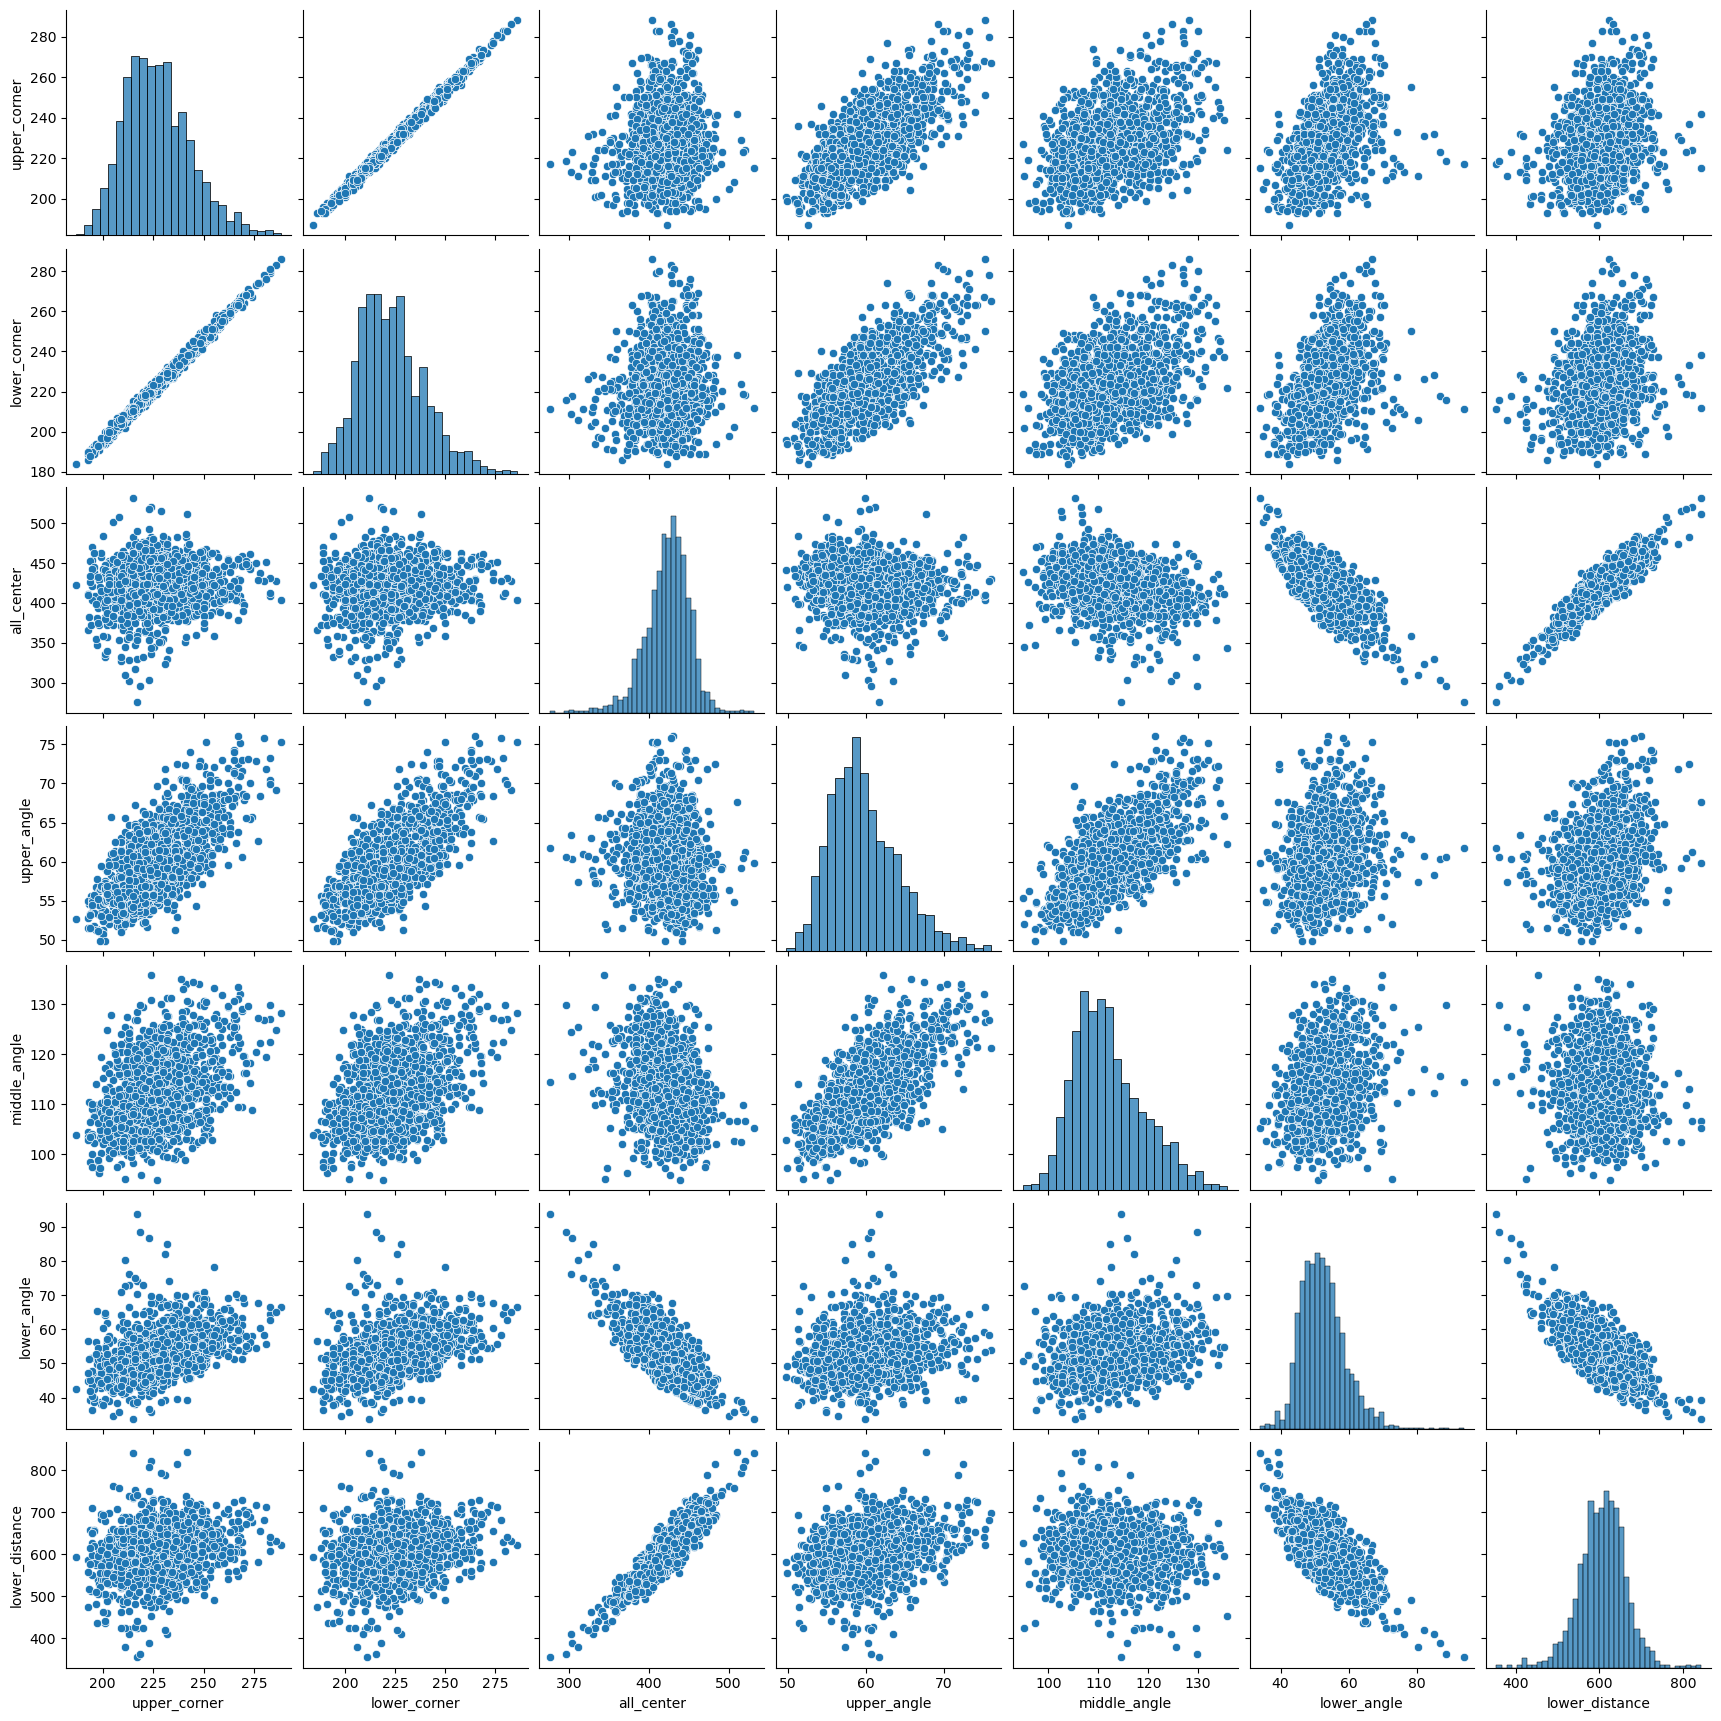

In [14]:
sns.pairplot(df_features)
plt.show()

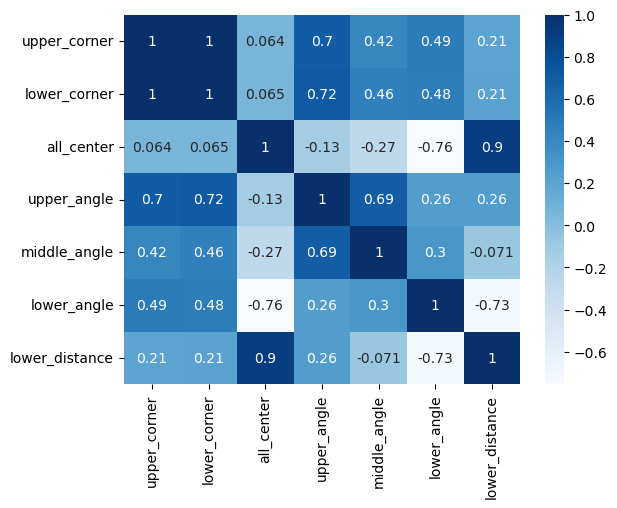

In [15]:
correlation = df_features.corr()
sns.heatmap(correlation, annot=True, cbar=True, cmap="Blues")
plt.show()

In [57]:
model = KMeans(n_clusters=6, random_state=12)
X = df_features[["upper_angle", "lower_corner", "all_center"]].values
df_all = pd.read_csv("Nose Features.csv")
image_name_path = df_all['image_name']
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
model.fit(scaled_X)

KMeans(n_clusters=6, random_state=12)

In [58]:
from sklearn.metrics import davies_bouldin_score
label = model.predict(scaled_X)
davis_metric = davies_bouldin_score(scaled_X, label)
print("Davies Bouldin metric:", davis_metric)

Davies Bouldin metric: 1.1966601048572432


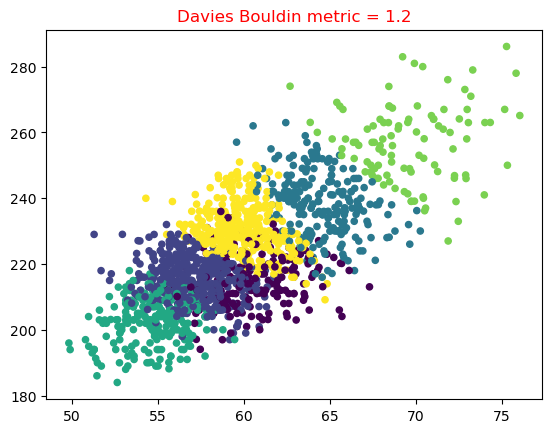

In [59]:
label = model.predict(scaled_X)
plt.scatter(X[:, 0], X[:, 1], c=label, s=20, cmap='viridis')
plt.title(f"Davies Bouldin metric = {round(davis_metric, 2)}", c='red')

# centers = model.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='cyan', s=40, alpha=0.5, marker='x')
plt.show()

In [61]:
# os.mkdir("6NN Results/cluster 0")
# os.mkdir("6NN Results/cluster 1")
# os.mkdir("6NN Results/cluster 2")
# os.mkdir("6NN Results/cluster 3")
# os.mkdir("6NN Results/cluster 4")
# os.mkdir("6NN Results/cluster 5")

In [75]:
# result_path = os.path.join("6NN Results/")
# result_folders = os.listdir(result_path)
# result_save_folders = []
# for folder in result_folders:
#     temp = os.path.join(f"6NN Results/{folder}")
#     result_save_folders.append(temp)

# six_NN_labels = model.labels_

# dataset_images_path = []
# for i in range(len(image_name_path)):
#     temp = os.path.join(f"C:/Users/Sina/Desktop/temp/Arbirtary Project/Dataset/{image_name_path[i]}")
#     dataset_images_path.append(temp)

In [81]:
# i = 0
# for label in six_NN_labels:
#     if label == 0:
#         image = os.path.join(f"C:/Users/Sina/Desktop/temp/Arbirtary Project/Dataset/{image_name_path[i]}")
#         shutil.copy(image, result_save_folders[0])
#     elif label == 1:
#         image = os.path.join(f"C:/Users/Sina/Desktop/temp/Arbirtary Project/Dataset/{image_name_path[i]}")
#         shutil.copy(image, result_save_folders[1])
#     elif label == 2:
#         image = os.path.join(f"C:/Users/Sina/Desktop/temp/Arbirtary Project/Dataset/{image_name_path[i]}")
#         shutil.copy(image, result_save_folders[2])
#     elif label == 3:
#         image = os.path.join(f"C:/Users/Sina/Desktop/temp/Arbirtary Project/Dataset/{image_name_path[i]}")
#         shutil.copy(image, result_save_folders[3])
#     elif label == 4:
#         image = os.path.join(f"C:/Users/Sina/Desktop/temp/Arbirtary Project/Dataset/{image_name_path[i]}")
#         shutil.copy(image, result_save_folders[4])
#     elif label == 5:
#         image = os.path.join(f"C:/Users/Sina/Desktop/temp/Arbirtary Project/Dataset/{image_name_path[i]}")
#         shutil.copy(image, result_save_folders[5])
#     i+=1